In [1]:
from kan import KAN
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

# Pré-processamento dos dados

In [2]:
dataset_path = 'Dataset/KAN'

In [3]:
X = []
y = []

classes = ['NORMAL', 'PNEUMONIA', 'TUBERCULOSE']

In [4]:
for class_index, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        
        image = cv2.resize(image, (224, 224))
        image = image.flatten()
        
        X.append(image)
        y.append(class_index)

X = np.array(X)
y = np.array(y)

In [5]:
X = X / 255.0

In [6]:
print('Formato do X:', X.shape)
print('Formato do y:', y.shape)

Formato do X: (300, 150528)
Formato do y: (300,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
print('Formato do X_train:', X_train.shape)
print('Formato do y_train:', y_train.shape)

Formato do X_train: (210, 150528)
Formato do y_train: (210,)


In [9]:
print('Formato do X_test:', X_test.shape)
print('Formato do y_test:', y_test.shape)

Formato do X_test: (90, 150528)
Formato do y_test: (90,)


In [10]:
dataset = {}

dtype = torch.get_default_dtype()

dataset['train_input'] = torch.from_numpy(X_train).type(dtype)
dataset['test_input'] = torch.from_numpy(X_test).type(dtype)
dataset['train_label'] = torch.from_numpy(y_train).type(torch.long)
dataset['test_label'] = torch.from_numpy(y_test).type(torch.long)

# Implementação da arquitetura KAN

In [11]:
model = KAN(width=[X_train.shape[1], 3], grid=3, k=3, base_fun=torch.nn.ReLU())

checkpoint directory created: ./model
saving model version 0.0


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

MultKAN(
  (base_fun_name): ReLU()
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): ReLU()
    )
  )
  (base_fun): ReLU()
  (symbolic_fun): ModuleList(
    (0): Symbolic_KANLayer()
  )
)

In [13]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

In [14]:
results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss());
results['train_acc'][-1], results['test_acc'][-1]

| train_loss: 0.00e+00 | test_loss: 9.66e-01 | reg: 4.62e+04 | : 100%|█| 20/20 [1:01:27<00:00, 184.3


saving model version 0.1


(1.0, 0.9333333373069763)

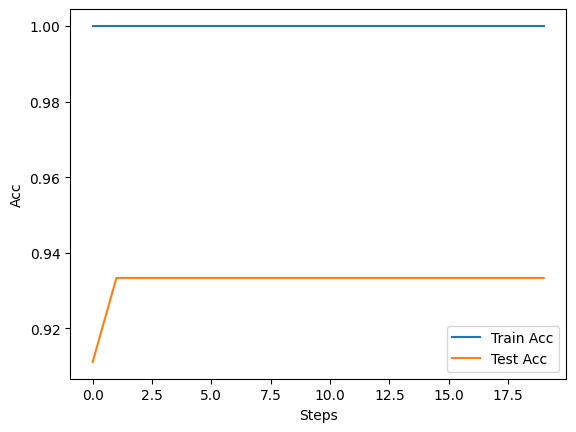

In [15]:
plt.plot(results['train_acc'], label='Train Acc')
plt.plot(results['test_acc'], label='Test Acc')
plt.xlabel('Steps')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [17]:
test_outputs = model(dataset['test_input'])
test_predictions = torch.argmax(test_outputs, dim=1).numpy()

# Métricas de avaliação

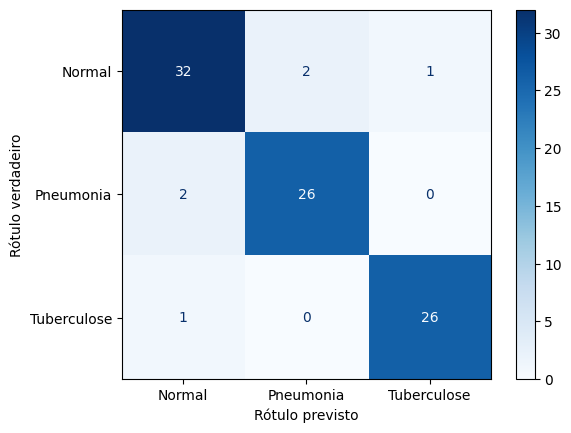

In [19]:
cm = confusion_matrix(y_test, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia', 'Tuberculose'])
disp.plot(cmap=plt.cm.Blues)

plt.xlabel('Rótulo previsto')
plt.ylabel('Rótulo verdadeiro')
plt.show()

In [20]:
accuracy = accuracy_score(y_test, test_predictions)
print(f"Acurácia: {accuracy:.2f}")

Acurácia: 0.93


In [21]:
precision = precision_score(y_test, test_predictions, average='weighted')
print(f"Precisão: {precision:.2f}")

Precisão: 0.93


In [22]:
recall = recall_score(y_test, test_predictions, average='weighted')
print(f"Recall: {recall:.2f}")

Recall: 0.93


In [23]:
f1 = f1_score(y_test, test_predictions, average='weighted')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.93


# Vetores dos rótulos verdadeiras e previstos

In [24]:
print("Verdadeiro:", y_test)

Verdadeiro: [2 2 1 0 2 2 1 1 0 1 2 0 2 0 1 2 2 2 1 1 0 1 2 2 1 0 2 2 1 2 0 1 0 0 2 1 0
 0 0 0 0 0 2 0 0 0 2 2 1 2 1 1 2 0 2 2 0 0 1 0 2 0 0 1 1 0 0 2 0 1 1 1 2 1
 1 2 0 0 0 2 1 1 0 1 0 1 1 0 0 0]


In [25]:
print("Previsto:", test_predictions)

Previsto: [2 2 1 0 2 2 1 1 0 1 2 0 2 0 1 2 2 2 1 1 0 1 2 2 1 0 2 2 1 2 0 1 0 0 2 1 0
 1 0 0 0 0 2 0 0 0 2 2 1 2 1 1 2 0 2 2 0 0 1 0 2 0 1 1 1 0 0 2 0 1 1 1 2 1
 1 0 2 0 0 2 1 1 0 0 0 1 0 0 0 0]
